In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cnmfsns as cn
cn.start_logging()

## Working with `Dataset` objects

Datasets can be created from pandas DataFrames quite easily.

In [3]:
import pandas as pd

data = pd.read_table("diamandis_data/diamandis_nobulk.txt", index_col=0)  # normalized expression data
metadata = pd.read_table("diamandis_data/diamandis_nobulk.metadata.txt", index_col=0)  # sample metadata

# create dataset from DataFrames
diamandis = cn.Dataset.from_df(data=data, obs=metadata, is_normalized=True, patient_id_col="patient_id")

They can be written to and read from AnnData files (h5ad format).

In [4]:
diamandis.write_h5ad("diamandis.h5ad")  # write to .h5ad file
diamandis = cn.Dataset.from_h5ad("diamandis.h5ad", patient_id_col="patient_id")  # read a .h5ad file

2023-03-23 14:39:36,339 [INFO] Writing to /home/tbverhey/github/cNMF-SNS/tutorial/diamandis.h5ad
2023-03-23 14:39:36,367 [INFO] Done


`Dataset` objects contain an AnnData object which can also be used for interfacing with other tools

In [5]:
diamandis.adata

AnnData object with n_obs × n_vars = 77 × 3560
    obs: 'patient_id', 'simple_category', 'detailed_category', 'age', 'sex', 'location of resection', 'ATRX', 'p53', 'MGMT'
    uns: 'cnmfsns_version', 'history', 'is_normalized', 'odg'

cNMF-SNS can recognize and import AnnData .h5ad files whether they are created in [Seurat](https://satijalab.org/seurat/archive/v2.4/conversion_vignette.html), [scanpy](https://scanpy.readthedocs.io/en/stable/usage-principles.html#anndata), or other single-cell software tools.

In [6]:
import scanpy

pbmc_adata = scanpy.datasets.pbmc3k()
pbmc_dataset = cn.Dataset.from_anndata(pbmc_adata)

  0%|          | 0.00/5.58M [00:00<?, ?B/s]

## Modelling mean and dispersion of genes

In [7]:
diamandis.compute_gene_stats()
diamandis.adata.var.head()  # results are stored in dataset object

,mean,rank_mean,variance,sd,missingness,log_mean,log_variance,mean_counts,odscore_excluded,resid_log_variance,odscore,gam_fittedvalues,vscore
A1BG,1.839333e+07,2152.0,1.787097e+14,1.336824e+07,0.0,7.264660,14.252150,1.839333e+07,False,0.090640,1.109992,14.161510,1.621348
A2M,2.338366e+08,3351.0,2.278611e+16,1.509507e+08,0.0,8.368914,16.357672,2.338366e+08,False,0.040062,1.047204,16.317609,4.806647
AAAS,2.478940e+06,203.0,9.438756e+11,9.715326e+05,0.0,6.394266,11.974916,2.478940e+06,False,-0.186994,0.806312,12.161910,0.077113
AAK1,1.713328e+07,2096.0,2.520759e+14,1.587690e+07,0.0,7.233840,14.401531,1.713328e+07,False,0.294975,1.404389,14.106556,2.489859
AARS1,1.069756e+08,3146.0,9.684864e+14,3.112051e+07,0.0,8.029285,14.986094,1.069756e+08,False,-0.652043,0.472040,15.638138,0.763087


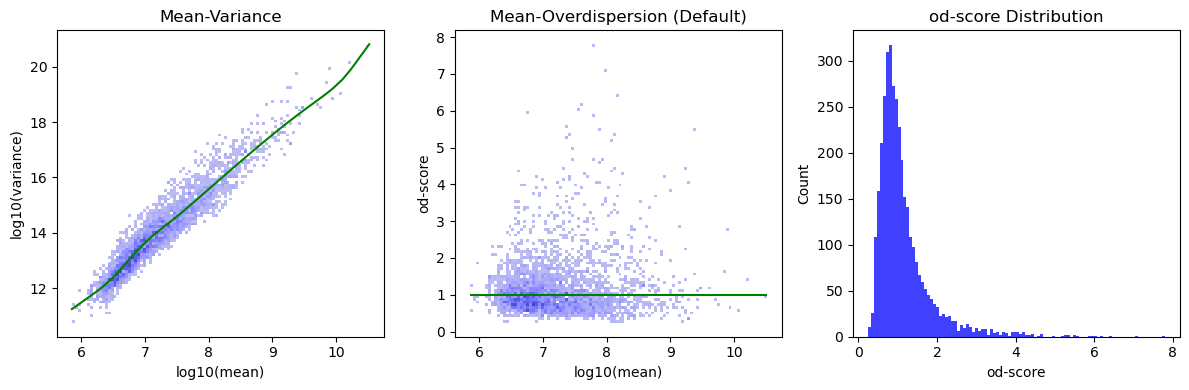

In [8]:
figs = cn.plot_feature_dispersion(diamandis)

## Selecting overdispersed genes

2023-03-23 14:39:42,087 [INFO] 1612 genes selected for factorization


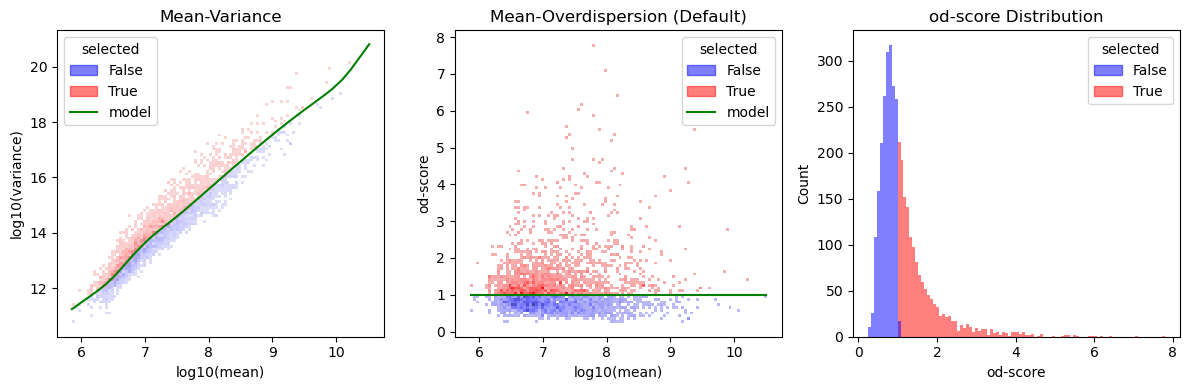

In [9]:
diamandis.select_overdispersed_genes()
figs = cn.plot_feature_dispersion(diamandis, show_selected=True)

Default parameters for `select_overdispersed_genes()` results in about 50% of genes as being overdispersed:

In [10]:
diamandis.adata.var["selected"].value_counts()

False    1948
True     1612
Name: selected, dtype: int64

## Factorization

In [11]:
cnmf_results_dir = "cnmf_results"
run_name = "diamandis"
# by default, k=2-60 is run with n_iter=200. For this demo, we will speed it up by drastically subsetting.
kvals = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
kvals = [2, 3 ,4, 5, 6, 7, 8]
n_iter = 10

cnmf_run = diamandis.initialize_cnmf(output_dir=cnmf_results_dir, name=run_name, kvals=kvals, n_iter=n_iter)

cnmf_run.factorize(verbose=False)
cnmf_run.postprocess()

# Merges cNMF results into the `Dataset` object
diamandis.add_cnmf_results(cnmf_output_dir=cnmf_results_dir, cnmf_name=run_name)
diamandis.write_h5ad("diamandis.h5ad")  # overwrite original file

2023-03-23 14:39:47,332 [INFO] Factorization outputs (individual iterations) were found for all values of k. No missing files were detected.
2023-03-23 14:39:47,333 [INFO] Merging iterations for k=2
2023-03-23 14:39:47,334 [INFO] Combining factorizations for k=2.
2023-03-23 14:39:47,362 [INFO] Merging iterations for k=3
2023-03-23 14:39:47,364 [INFO] Combining factorizations for k=3.
2023-03-23 14:39:47,394 [INFO] Merging iterations for k=4
2023-03-23 14:39:47,396 [INFO] Combining factorizations for k=4.
2023-03-23 14:39:47,429 [INFO] Merging iterations for k=5
2023-03-23 14:39:47,431 [INFO] Combining factorizations for k=5.
2023-03-23 14:39:47,466 [INFO] Merging iterations for k=6
2023-03-23 14:39:47,468 [INFO] Combining factorizations for k=6.
2023-03-23 14:39:47,505 [INFO] Merging iterations for k=7
2023-03-23 14:39:47,508 [INFO] Combining factorizations for k=7.
2023-03-23 14:39:47,547 [INFO] Merging iterations for k=8
2023-03-23 14:39:47,550 [INFO] Combining factorizations for k=8

## Stability-Error Plot

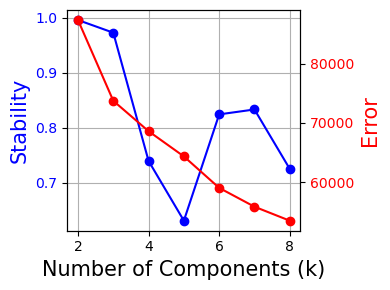

In [12]:
fig = cn.plot_stability_error(diamandis, figsize=[4,3])

fig.savefig("stability-error.pdf")  # Save figures in PDF or PNG format

## Plot GEP usage

In [13]:
diamandis.get_usages()

2                       3                           \
                   1           2           1           2            3   
sample_1   286095.84  68228.2700  275171.280  49467.5230   38614.9530   
sample_10  275235.38  43244.8160  221638.940  29174.7480   71201.0160   
sample_11  303914.47  47215.4300  314376.000  30018.7580   19576.1370   
sample_12  325178.60  25440.9240  351844.880   8013.7640    7259.5913   
sample_13  322546.94  10328.8580  269360.970   2312.5498   66956.5700   
...              ...         ...         ...         ...          ...   
sample_75  381398.60   4542.0195   12505.815   2086.0762  339298.4000   
sample_76  340732.88   7951.5320   61108.523   4046.9680  261210.9400   
sample_77  375903.25   5597.4160   25802.156   3742.3990  321932.4400   
sample_8   295941.16  26007.5450  303465.220  10225.1600   21063.4320   
sample_9   353140.25  24241.8280  358534.970   9594.5340   23786.5270   

                    4                                                 5  ...  \
                    1           2            3            4           1  ...   
sample_1   222190.390  35029.7770   27135.6950   85381.0500  206153.880  ...   
sample_10  178897.450  18786.6040   59487.9920   71462.3750  110053.400  ...   
sample_11  294959.900  29226.3320   12122.5090   12163.3180   27720.295  ...   
sample_12  331527.900   9472.7060    2711.7456    5870.2056  251940.670  ...   
sample_13  250354.750   1434.2391   57509.5470   21174.2380   98614.930  ...   
...               ...         ...          ...          ...         ...  ...   
sample_75   18326.713   1372.2765  330459.7800    3331.5435   10885.153  ...   
sample_76   62991.780   2120.6104  247064.0300   15033.4460   27139.078  ...   
sample_77   35125.957   2516.4214  307963.6000    5918.5800   10471.539  ...   
sample_8   214562.550    815.1912    8177.2314  129151.7660  200111.980  ...   
sample_9   341536.600  11309.1560   16085.3700    4823.5933   43950.562  ...   

                    7                         8                            \
                    6            7            1            2            3   
sample_1    51346.074   6904.75600  31895.07400   54500.6760  188090.0000   
sample_10   20469.336   1389.44890  16825.77500   38617.5350  143734.6200   
sample_11   24752.799   5677.21040  27896.95500  209197.9200   19443.8540   
sample_12  254599.020   3121.79250   2345.43650   60706.4730   14407.3180   
sample_13   27062.250   2009.77310    607.24713  138777.9800   73080.5900   
...               ...          ...          ...          ...          ...   
sample_75    5087.703   1634.62780   1105.42480   24207.8050    4389.1216   
sample_76    6659.468    890.35803   1106.76370   36790.4530   48610.1900   
sample_77    5164.763   1013.90393    134.66188    1157.1572    1158.0033   
sample_8    27246.750  14990.39900    931.52026   71997.6300  218282.5300   
sample_9    69146.670   3361.86470   8842.59400  248768.9200   12584.1760   

                                                                           
                    4            5            6             7           8  
sample_1   49568.5040   11995.9710   43240.7070   12310.78600  4436.55000  
sample_10  12650.1530   15157.7660   13261.5400  105196.64000  1787.66600  
sample_11  16701.3630    8104.2354   21108.2970   35342.45700  4445.92000  
sample_12  14833.0500    1443.9368  245352.2200     390.87520  2171.87430  
sample_13  44729.6900   45933.7970   22096.0160   12543.97000  1246.35140  
...               ...          ...          ...           ...         ...  
sample_75  22612.3240  292115.7800    4342.7725    6304.22500  1349.47140  
sample_76   4954.1777  209204.0300    4694.4795   32360.76800   684.19977  
sample_77   1817.4276  209361.3800     575.6682  138564.52000   523.26654  
sample_8   56791.8120    1123.9996   19455.9240     271.59528  8717.56600  
sample_9   10100.8670   17603.5940   65361.1500    1523.94820  1926.12590  

[77 rows x 35 columns]

2023-03-23 14:40:10,755 [INFO] Choosing distinct colors for metadata layer patient_id
2023-03-23 14:40:10,881 [INFO] Choosing distinct colors for metadata layer simple_category
2023-03-23 14:40:10,898 [INFO] Choosing distinct colors for metadata layer detailed_category
2023-03-23 14:40:10,914 [INFO] Choosing distinct colors for metadata layer sex
2023-03-23 14:40:10,921 [INFO] Choosing distinct colors for metadata layer location of resection
2023-03-23 14:40:11,000 [INFO] Choosing distinct colors for metadata layer ATRX
2023-03-23 14:40:11,007 [INFO] Choosing distinct colors for metadata layer p53
2023-03-23 14:40:11,017 [INFO] Choosing distinct colors for metadata layer MGMT


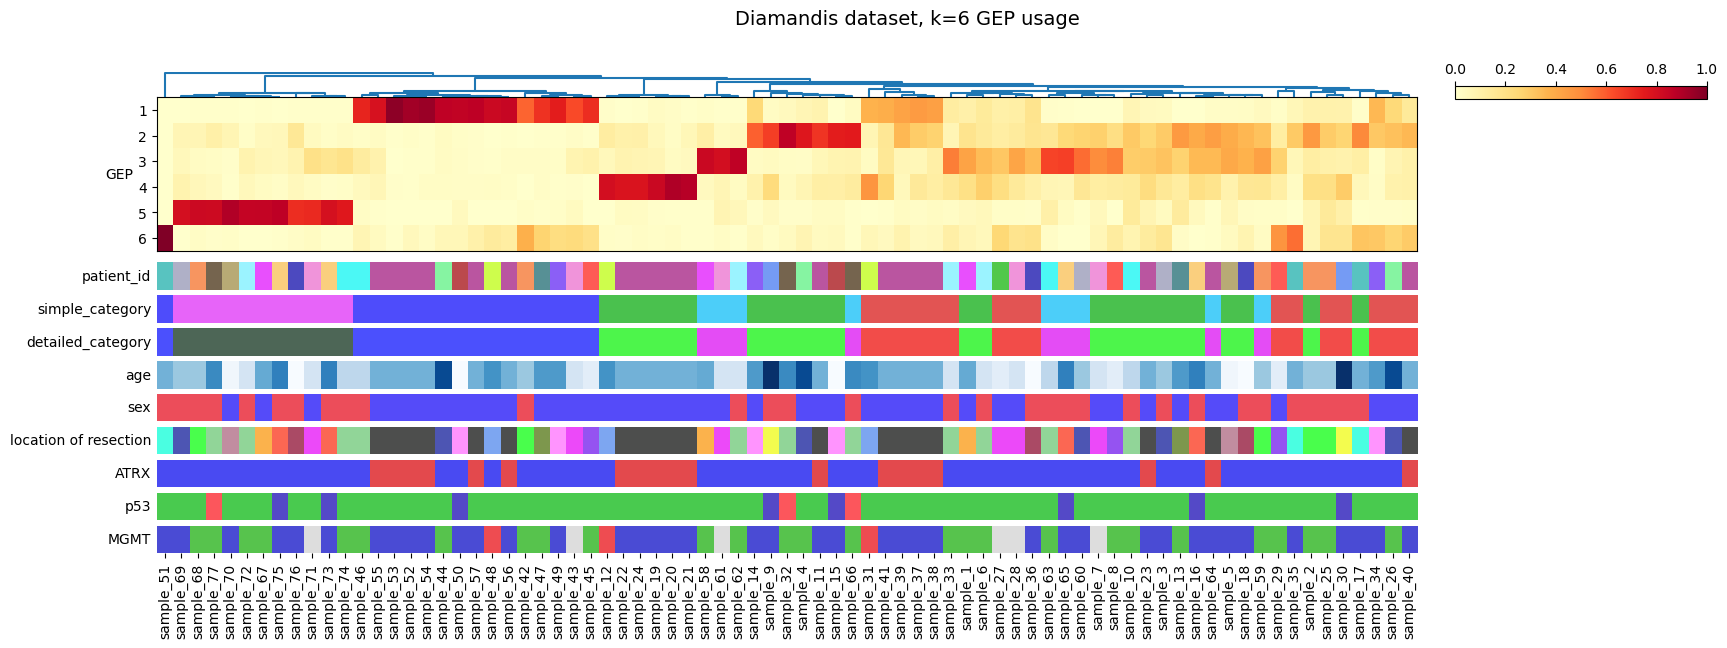

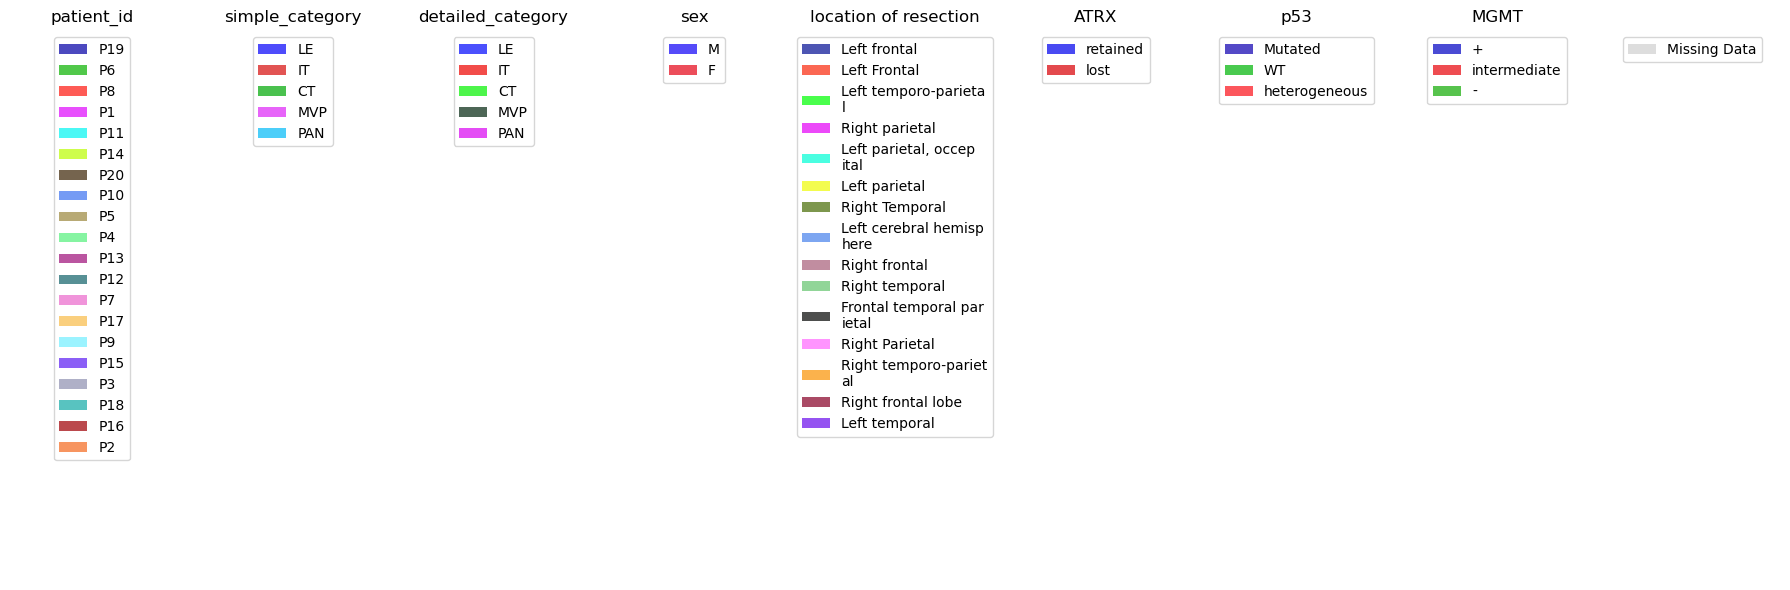

In [14]:
colors = cn.Colors.from_dataset(diamandis, pastel_factor=0.4)  # create distinct colors for metadata tracks


fig = cn.plot_usage_heatmap(diamandis, k=6, colors=colors,
                                     title="Diamandis dataset, k=6 GEP usage")
fig.savefig("k6_usages_heatmap.pdf")

fig_legend = colors.plot_metadata_colors_legend()
fig.savefig("diamandis_metadata_colors_legend.pdf")

## Factorize a second dataset for integration

In [15]:
data = pd.read_csv("cptac_data/cptac_gbm.csv", index_col=0).T  # normalized expression data
metadata = pd.read_table("cptac_data/cptac_gbm.metadata.txt", index_col=0)  # sample metadata

# create dataset from CPTAC example data
cptac = cn.Dataset.from_df(data=data, obs=metadata, is_normalized=True, patient_id_col = "patient_id")
cptac.compute_gene_stats()
cptac.select_overdispersed_genes()

# creates directory with cNMF results
cnmf_results_dir = "cnmf_results"
run_name = "cptac"
cnmf_run = cptac.initialize_cnmf(output_dir=cnmf_results_dir, name=run_name, kvals=kvals, n_iter=n_iter)
cnmf_run.factorize(verbose=False)
cnmf_run.postprocess()

# Merges cNMF results into the `Dataset` object
cptac.add_cnmf_results(cnmf_output_dir=cnmf_results_dir, cnmf_name=run_name)
cptac.write_h5ad("cptac.h5ad")  # write to h5ad file

2023-03-23 14:40:15,138 [INFO] 4554 genes selected for factorization
2023-03-23 14:41:51,970 [INFO] Factorization outputs (individual iterations) were found for all values of k. No missing files were detected.
2023-03-23 14:41:51,972 [INFO] Merging iterations for k=2
2023-03-23 14:41:51,975 [INFO] Combining factorizations for k=2.
2023-03-23 14:41:52,107 [INFO] Merging iterations for k=3
2023-03-23 14:41:52,110 [INFO] Combining factorizations for k=3.
2023-03-23 14:41:52,225 [INFO] Merging iterations for k=4
2023-03-23 14:41:52,228 [INFO] Combining factorizations for k=4.
2023-03-23 14:41:52,332 [INFO] Merging iterations for k=5
2023-03-23 14:41:52,335 [INFO] Combining factorizations for k=5.
2023-03-23 14:41:52,439 [INFO] Merging iterations for k=6
2023-03-23 14:41:52,442 [INFO] Combining factorizations for k=6.
2023-03-23 14:41:52,549 [INFO] Merging iterations for k=7
2023-03-23 14:41:52,552 [INFO] Combining factorizations for k=7.
2023-03-23 14:41:52,660 [INFO] Merging iterations fo

## Integrate multiple datasets together

In [16]:
datasets = {"CPTAC": cptac,
            "Diamandis": diamandis}
integration = cn.Integration(datasets=datasets)  # create an integration object
colors = cn.Colors.from_integration(integration)  # create color scheme for metadata and datasets
colors.to_toml("colors.toml")  # save to file for reference (TOML file can be re-imported)

2023-03-23 14:42:27,593 [INFO] nancorrmp found. Calculating Pearson correlation matrix using 16 CPUs.
2023-03-23 14:42:27,885 [INFO] Choosing distinct dataset colors
2023-03-23 14:42:27,898 [INFO] Choosing distinct colors for metadata layer patient_id
2023-03-23 14:42:31,484 [INFO] Choosing distinct colors for metadata layer simple_category
2023-03-23 14:42:31,494 [INFO] Choosing distinct colors for metadata layer detailed_category
2023-03-23 14:42:31,504 [INFO] Choosing distinct colors for metadata layer multiomic
2023-03-23 14:42:31,516 [INFO] Choosing distinct colors for metadata layer r_wang_cancer_cell_2017
2023-03-23 14:42:31,528 [INFO] Choosing distinct colors for metadata layer d_methyl
2023-03-23 14:42:31,553 [INFO] Choosing distinct colors for metadata layer d_methyl_mnp
2023-03-23 14:42:31,601 [INFO] Choosing distinct colors for metadata layer is_gcimp
2023-03-23 14:42:31,606 [INFO] Choosing distinct colors for metadata layer immune
2023-03-23 14:42:31,619 [INFO] Choosing di

In [17]:
integration.k_subset

(2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60)

Identify gene overlap between datasets

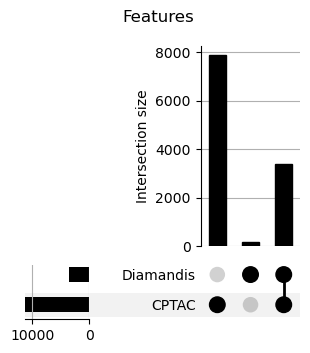

In [18]:
cn.plot_features_upset(integration)

A subset of these are identified as overdispersed in each dataset, and there is a significant overlap between datasets, indicating similar variation is seen in the two separate datasets.

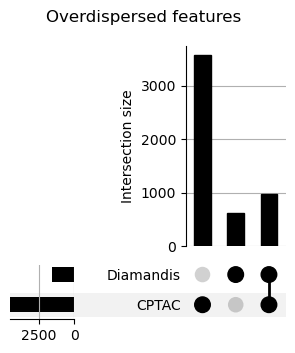

In [19]:
cn.plot_overdispersed_features_upset(integration)

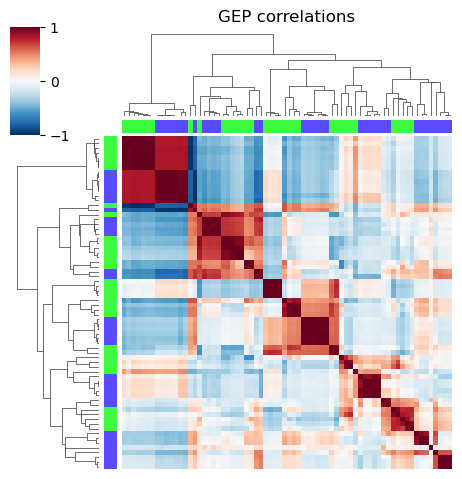

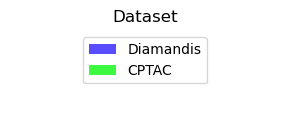

In [20]:
# plot the correlation matrix of all GEPs to each other
fig = cn.plot_gep_correlation_matrix(integration, colors=colors, figsize=[6, 6], hide_gep_labels=True)
fig.savefig("correlation_matrix.pdf")

# plot the legend separately as it applies to multiple figures
figlegend = colors.plot_dataset_colors_legend()
figlegend.savefig("datasets_legend.pdf")

To see if the `max_median_corr` threshold removed any ranks from either of the datasets, the following plot can be generated. The x-axis is the max-k, a threshold that excludes ranks above. The y-axis is the median of the correlation coefficients for all non-self edges in the correlation network. As this this threshold is slowly increased, the number of ranks, and thus nodes, and thus edges increases. The correlation between all edges slowly increases. In some datasets, this median of correlations will exceed 0 at high ranks. These high ranks will be excluded by this filter.

You can easily see for each rank whether there is a cNMF result, the stability/error of the result, as well as whether the ranks will be excluded on the basis of a max-k filter (derived from the max_median_corr parameter). You can also see which ranks will be selected (selected_k) based on automatic node subsetting for the final SNS maps.

In [21]:
integration.k_table

CPTAC                                                                  \
  cNMF result max_k_filter_pass max_k_median_corr prediction_error selected_k   
2        True              True         -0.991544    297193.656250       True   
3        True              True         -0.457867    271560.437500       True   
4        True              True         -0.309910    255610.328125       True   
5        True              True         -0.224848    241719.406250       True   
6        True              True         -0.157255    232482.234375       True   
7        True              True         -0.139184    228166.968750       True   
8        True              True         -0.138656    222048.953125       True   

              Diamandis                                                       \
  stability cNMF result max_k_filter_pass max_k_median_corr prediction_error   
2  0.991861        True              True         -0.999227     87358.273438   
3  0.813175        True              True         -0.452676     73738.859375   
4  0.666177        True              True         -0.220161     68611.093750   
5  0.659406        True              True         -0.144826     64361.875000   
6  0.667921        True              True         -0.135058     59056.566406   
7  0.469416        True              True         -0.116828     55881.218750   
8  0.424627        True              True         -0.116563     53524.652344   

                        
  selected_k stability  
2       True  0.995720  
3       True  0.972703  
4       True  0.739878  
5       True  0.631443  
6       True  0.824451  
7       True  0.833351  
8       True  0.725453

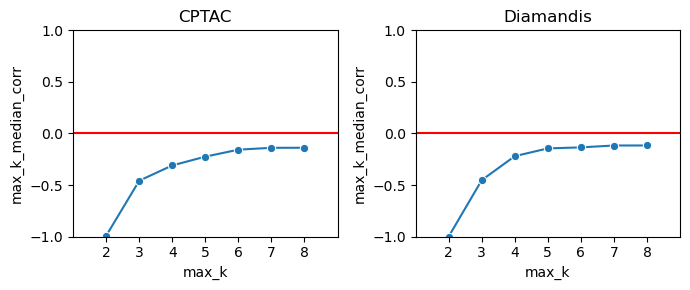

In [22]:
fig = cn.plot_rank_reduction(integration)

You can see that no k-values exceeded the threshold, so no max_k filter was applied. Now, let's plot the distribution of correlations for GEPs within and between datasets. This will show the min_corr thresholds. There is one threshold per dataset pair, and one threshold for within each dataset.

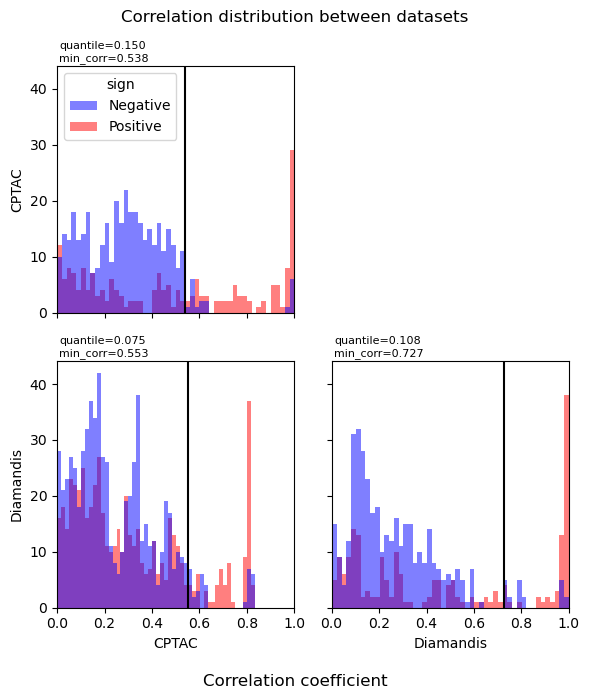

In [23]:
# fig = cn.plot_pairwise_corr(integration)
fig2 = cn.plot_pairwise_corr_overlaid(integration)  # overlaid plots show the mirrored distributions

See the number of nodes from each dataset with and without the node filters (including maxk and selectedk filters) and the edge filter (min_corr thresholds).

In [24]:
integration.get_node_table()

Node filter none         maxk         selectedk        
Edge Filter none mincorr none mincorr      none mincorr
CPTAC         35      35   35      35        35      35
Diamandis     35      35   35      35        35      35

## Create an SNS integration

2023-03-23 14:42:34,974 [INFO] Community search: algorithm = greedy_modularity, resolution = 1
2023-03-23 14:42:35,027 [INFO] Creating community network


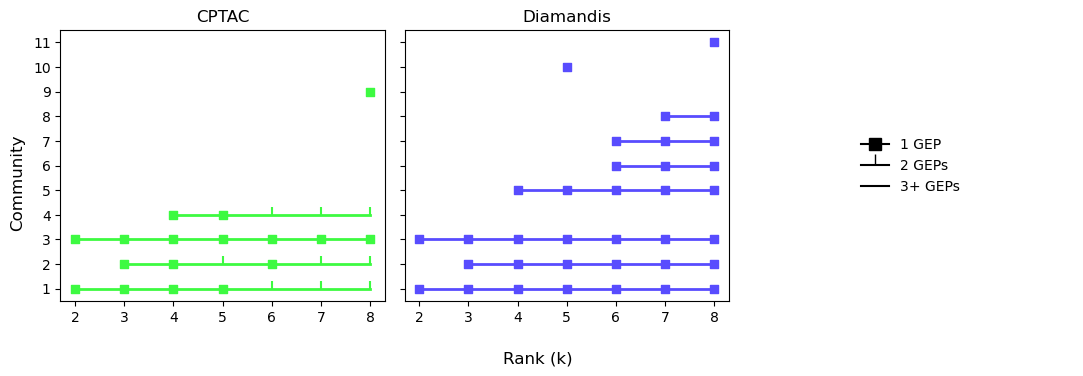

In [25]:
snsmap = cn.SNS(integration)
snsmap.community_search(algorithm="greedy_modularity", resolution=1)
fig = cn.plot_community_by_dataset_rank(snsmap, colors)

# Plot an SNS Map

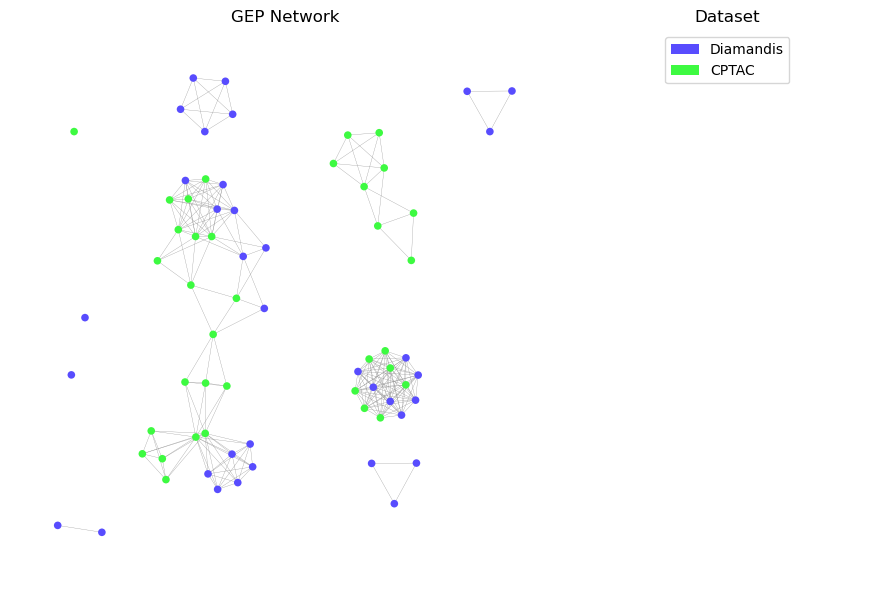

In [26]:
snsmap.compute_layout(algorithm="neato")
fig = cn.plot_gep_network_datasets(snsmap, colors, node_size_kval=False)

How many samples have each GEP/node as their highest usage GEP? 

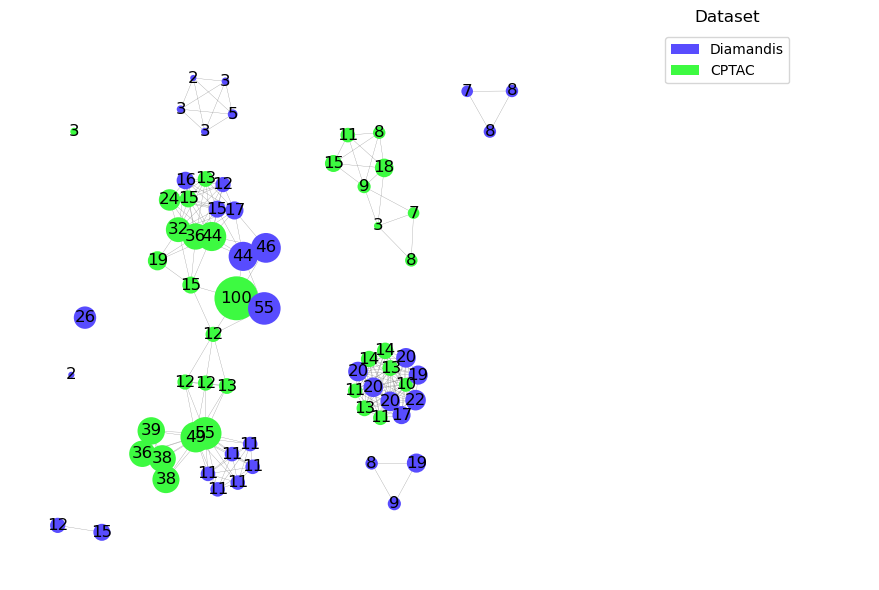

In [27]:
fig = cn.plot_gep_network_nsamples(snsmap,
                                  colors,
                                  node_size=1e3,
                                  font_size=12,
                                  discretize=True)

How many patients is each GEP primarily associated to?

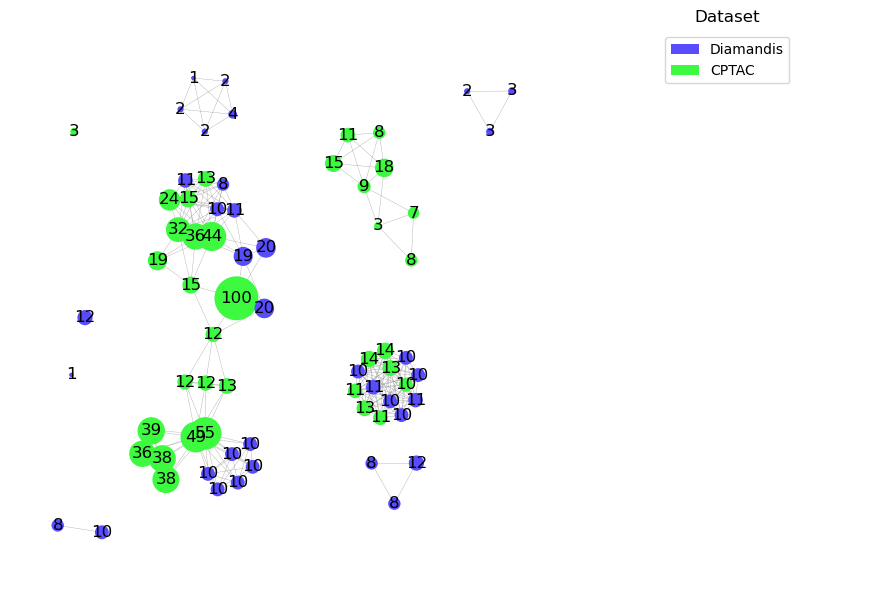

In [28]:
fig = cn.plot_gep_network_npatients(snsmap, colors, node_size=1e3, font_size=12)


Overrepresentation of sample categories for each GEP on the network

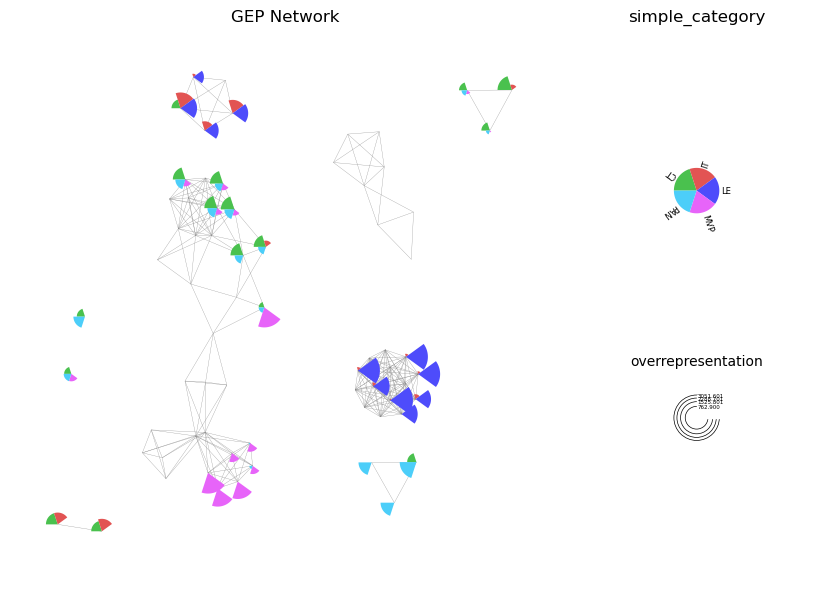

In [29]:
fig = cn.plot_overrepresentation_gep_network(snsmap, colors, subset_datasets="Diamandis", layer="simple_category")
fig.savefig("diamandis_overrepresentation.pdf")

And again, using the CPTAC annotations

In [30]:
fig = cn.plot_gep_overrepresentation_network(snsmap, colors, subset_datasets="CPTAC", layer="simple_category")
fig.savefig("cptac_overrepresentation.pdf")

AttributeError: module 'cnmfsns' has no attribute 'plot_gep_overrepresentation_network'

You can also look at continuous metadata correlated with GEP usage, like age:

# Identifying GEP Communities

2023-03-07 21:03:17,756 [INFO] Choosing distinct community colors


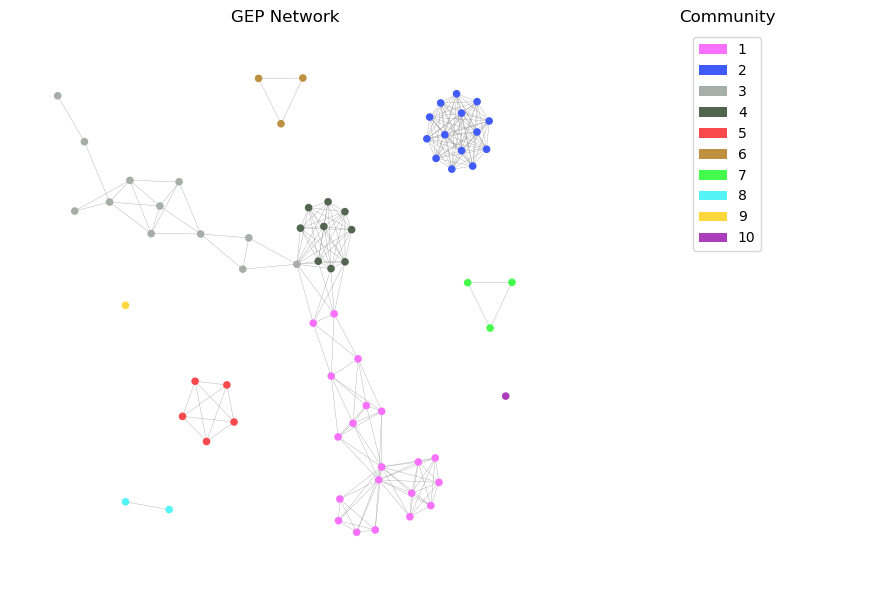

In [ ]:
colors.add_missing_community_colors(snsmap)
fig = cn.plot_gep_network_communities(snsmap, colors)

Plot a summary showing the size of each community (node size) and number of edges connecting communities (edge width).

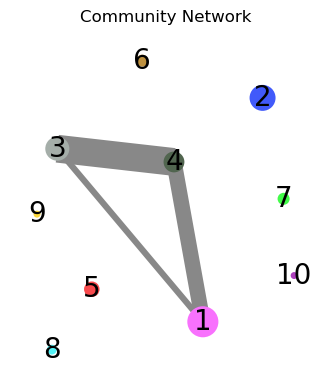

In [ ]:
fig = cn.plot_summary_community_network(snsmap, colors)

Plot GEP usage heatmap summarized by Community

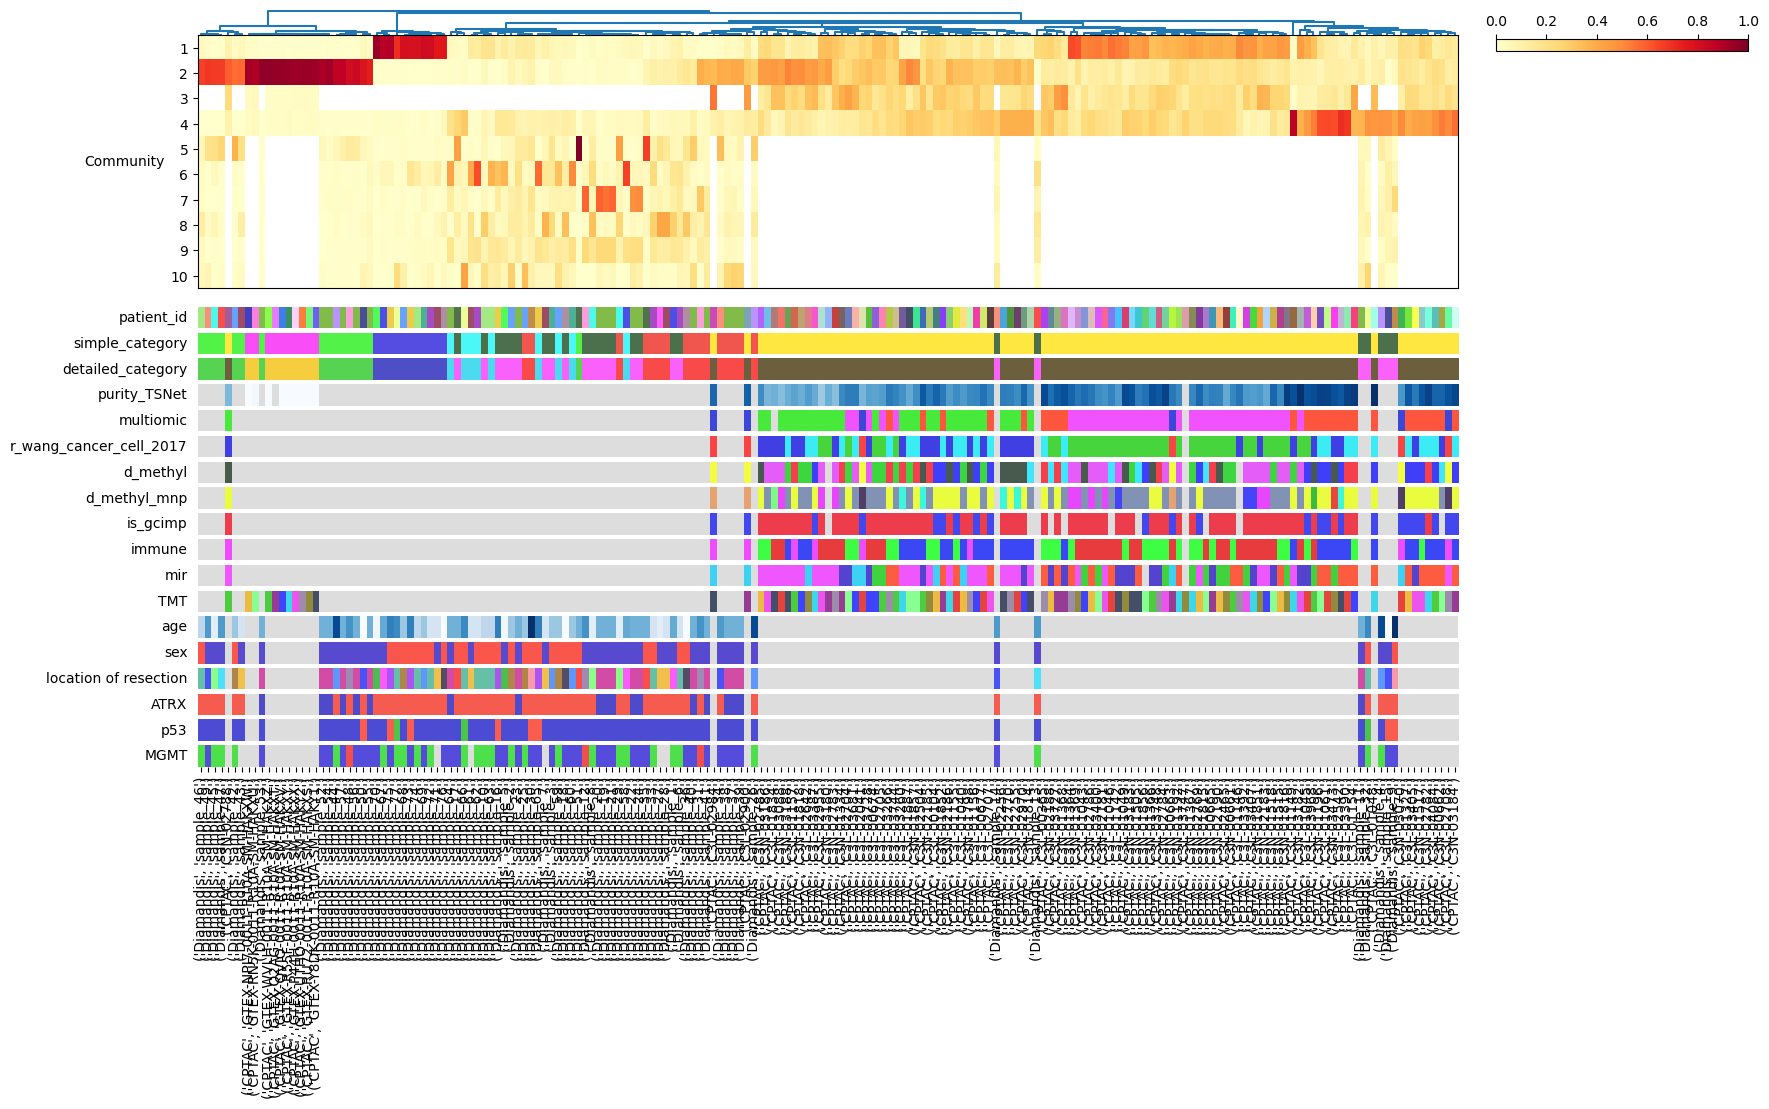

In [ ]:
fig = cn.plot_community_usage_heatmap(snsmap, colors)
# fig_legend = colors.plot_metadata_colors_legend()

## Correlation categorical variables with usage of GEPs, grouped by community

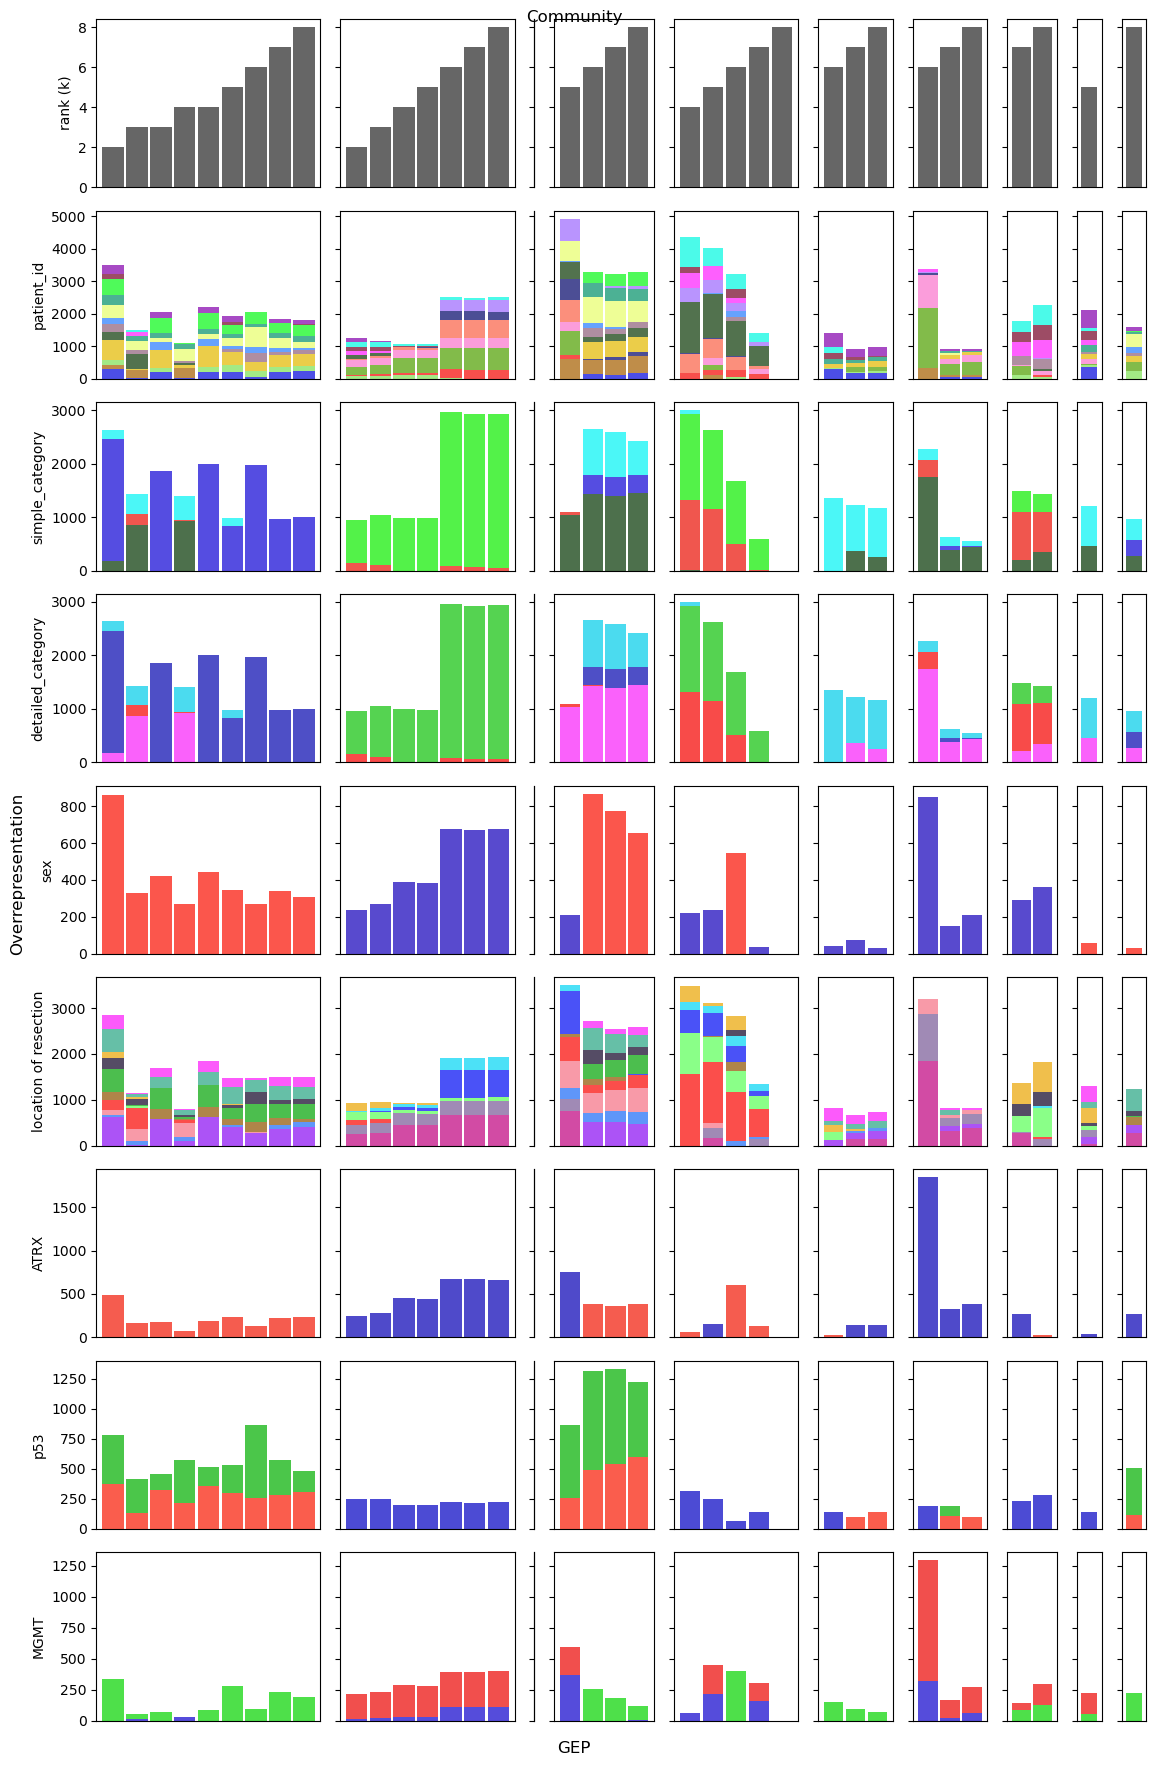

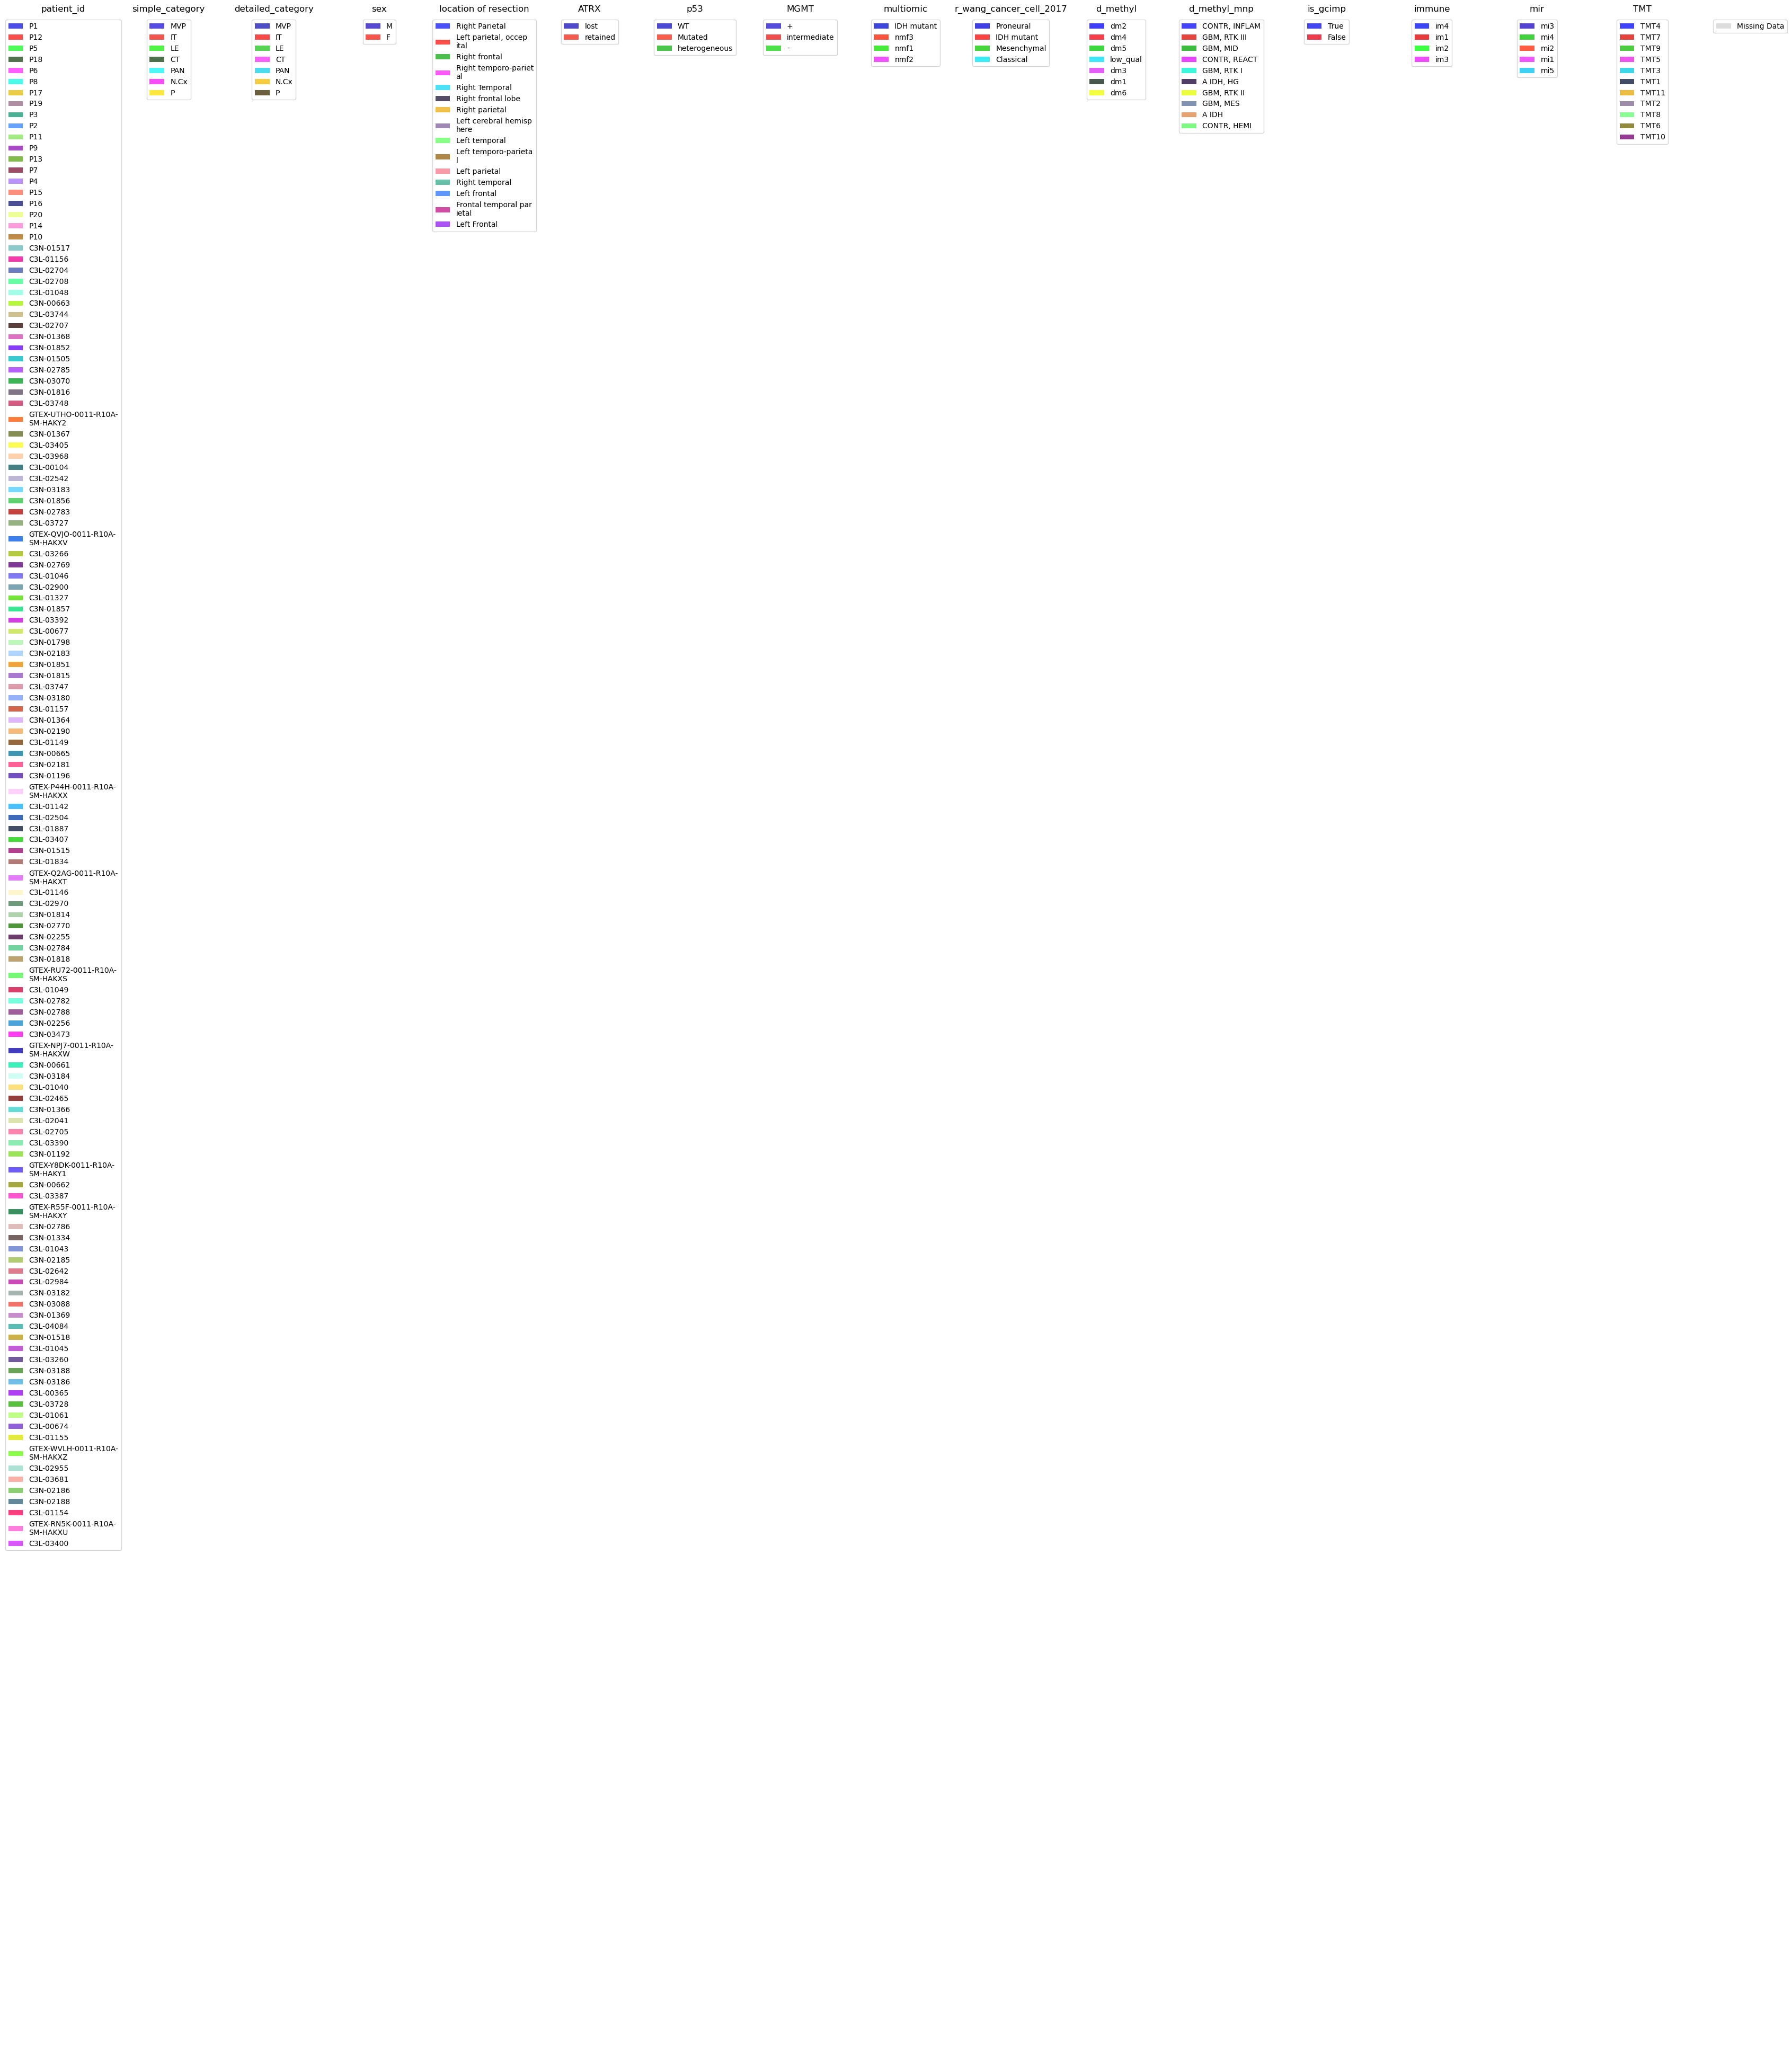

In [ ]:
fig = cn.plot_overrepresentation_gep_bar(snsmap, colors, dataset_name="Diamandis")
# fig_legend = colors.plot_metadata_colors_legend()

## Correlation GEPs in each community with continuous variables like `age`

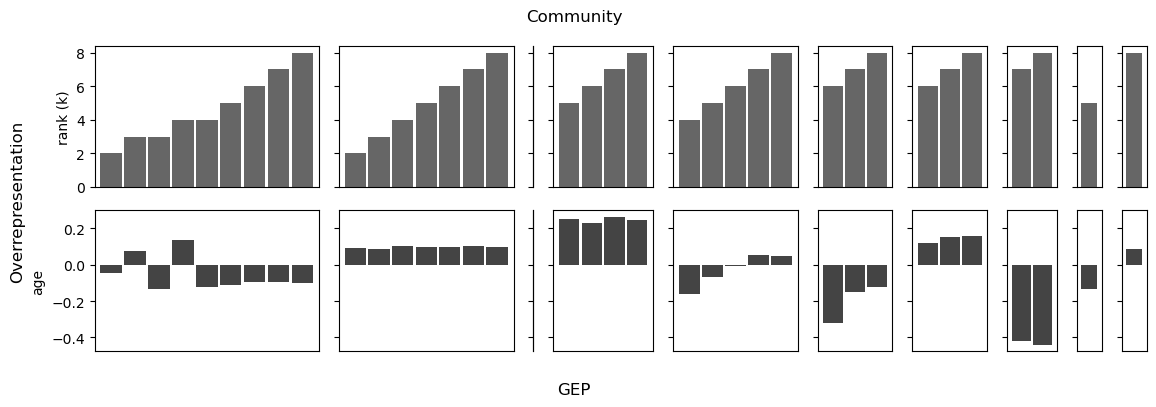

In [ ]:
fig = cn.plot_metadata_correlation_gep_bar(snsmap, colors, dataset_name="Diamandis")

# Community-level summary of overrepresentation

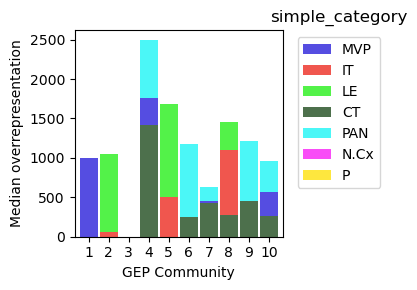

In [ ]:
fig = cn.plot_overrepresentation_community_bar(snsmap, colors, layer="simple_category", subset_datasets="Diamandis")

Or, plot it on the network:

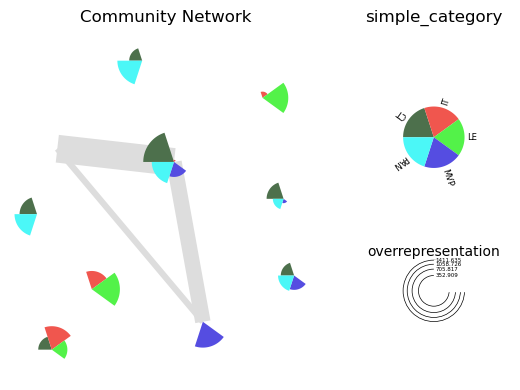

In [ ]:
fig = cn.plot_overrepresentation_community_network(snsmap, colors, layer="simple_category", pie_size=0.2, subset_datasets="Diamandis")

# Summarizing correlation with metadata

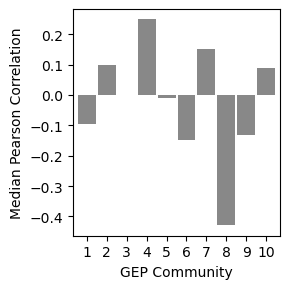

In [ ]:
fig = cn.plot_metadata_correlation_community_bar(snsmap, colors, layer="age", subset_datasets="Diamandis")

Or, plot it on the network:

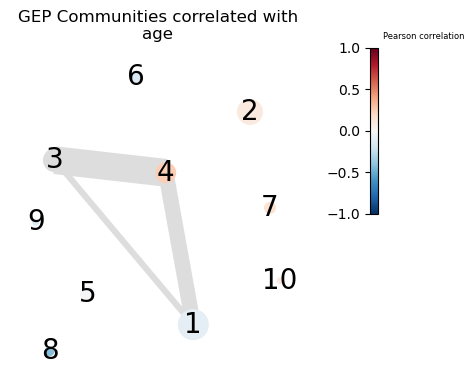

In [ ]:
fig = cn.plot_metadata_correlation_community_network(snsmap, colors, layer="age", subset_datasets="Diamandis")

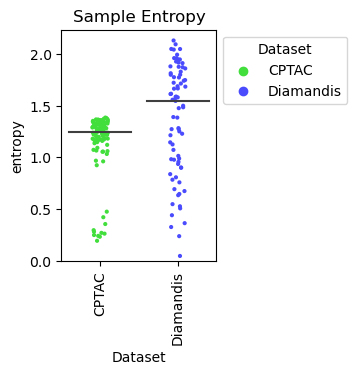

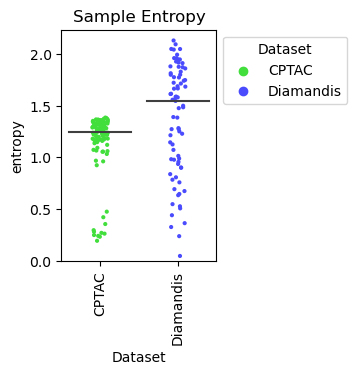

In [ ]:
cn.plot_sample_entropy(snsmap, colors)